In [1]:
%load_ext autoreload
%autoreload 2

## **[edge attr]** euclidean and normalized direction, 
## **[edge net]** 2 layers
## **[block dim]** 8,8,8,8
## **[loss]** stress 0.95 + AngularResolutionMeanSineLoss 0.05

In [2]:
from utils import *
from modules import *

In [3]:
torch.__version__

'1.5.0'

In [4]:
torch.cuda.device_count()

4

In [5]:
device = 'cuda:3' # 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [6]:
nvidia_smi.nvmlInit()
cuda = nvidia_smi.nvmlDeviceGetHandleByIndex(3)

In [7]:
config = Config('config-Copy56.json')
config

{'batchsize': 120,
 'epoch': {'end': None, 'start': 35},
 'log_period': 1,
 'lr': {'decay_rate': 0.99, 'decay_step': 1, 'initial': 0.001, 'override': None},
 'name': 'resoMeanSin.05_2l_dir_u_8888',
 'test': {'epoch': 498,
 'name': 'resoMeanSin.05_2l_dir_u_8888',
 'out_prefix': 'resoMeanSin.05_2l_dir_u_8888'}}

In [8]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.in_blocks = nn.ModuleList([
            GNNBlock(feat_dims=[2, 8, 8], bn=True, dp=0.2)
        ])
        self.hid_blocks = nn.ModuleList([
            GNNBlock(feat_dims=[8, 8, 8, 8], 
                     efeat_hid_dims=[16],
                     bn=True, 
                     act=True,
                     dp=0.2, 
                     extra_efeat='skip', 
                     euclidian=True, 
                     direction=True, 
                     residual=True)
            for _ in range(10)
        ])
        self.out_blocks = nn.ModuleList([
            GNNBlock(feat_dims=[8, 8], bn=True),
            GNNBlock(feat_dims=[8, 2], act=False)
        ])

    def forward(self, data, output_hidden=False, numpy=False, with_initial_pos=False):
        if with_initial_pos:
            v = data.x
        else:
            v = torch.rand_like(data.x) * 2 - 1
        
        hidden = []
        for block in chain(self.in_blocks, 
                           self.hid_blocks, 
                           self.out_blocks):
            v = block(v, data)
            if output_hidden:
                hidden.append(v.detach().cpu().numpy() if numpy else v)
        if not output_hidden:
            vout = v.detach().cpu().numpy() if numpy else v
        
        return hidden if output_hidden else vout

In [9]:
G_list, data_list = load_processed_data(G_list_file='G_list.pickle', 
                                        data_list_file='data_list.pickle')
train_loader = DataLoader(data_list[:10000], batch_size=config.batchsize, shuffle=True)
val_loader = DataLoader(data_list[11000:], batch_size=config.batchsize, shuffle=False)

In [10]:
criterion = CompositeLoss([MeanStressLoss(), AngularResolutionMeanSineLoss()], weights=[0.95, 0.05])

In [ ]:
if not os.path.isdir(f"../ckpt_{config.name}"):
    os.mkdir(f"../ckpt_{config.name}")
model = Model().to(device)
if config.epoch.start > 0:
    state_dict = torch.load(f"../ckpt_{config.name}/epoch_{config.epoch.start}.pt")
    model.load_state_dict(state_dict)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr.initial)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, 
                                            step_size=config.lr.decay_step, 
                                            gamma=config.lr.decay_rate)
loss_ep = []
print("=" * 50, file=open(f"{config.name}.log", "a"))
epoch = config.epoch.start + 1
with tqdm(total=len(train_loader), smoothing=0) as progress:
    while True:
        if config.lr.override is not None:
            optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr.override)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, 
                                                        step_size=config.lr.decay_step, 
                                                        gamma=config.lr.decay_rate)
        progress.reset()
        progress.set_description(desc=f"[epoch {epoch}/{config.epoch.end}]")
        train_loss, train_loss_comp = train(model, criterion, optimizer, train_loader, device, progress, cuda, output_components=True)
        loss_ep.append(train_loss)
        scheduler.step()
        if epoch % config.log_period == 0:
            torch.save(model.state_dict(), f"../ckpt_{config.name}/epoch_{epoch}.pt")
            val_losses, val_losses_comp = test(model, criterion, val_loader, device, output_components=True)
            print(f'{epoch}, train: {train_loss, train_loss_comp.tolist()}, val: {val_losses, val_losses_comp.tolist()}', 
                  file=open(f"{config.name}.log", "a"))
        if epoch == config.epoch.end:
            break
        epoch += 1

# Performance Testing

In [ ]:
model = torch.load(f'../ckpt_{config.name}/epoch_{config.test.epoch}.pt', map_location=torch.device(device))
criterion = CompositeLoss([EnergyLossVectorized(), AngularResolutionL2Loss()], weights=[0.1, 0.9])
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [10]:
model = Model().to(device)
state_dict = torch.load(f"../ckpt_{config.name}/epoch_{config.test.epoch}.pt")
model.load_state_dict(state_dict)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [11]:
ground_truth = pd.read_csv('scaled_gt_loss.csv', index_col=0)
folder_name = f'{config.test.name}_test'
if not os.path.isdir(folder_name):
    os.mkdir(folder_name)


stress 0.10563885 0.16833667
reso loss 0.29747382 0.039588246
score 0.6035310201346874 0.08390543577294586
min degree 69.587932354942 129.8650008144013
loss ratio 4.236311821433126 10.746233409585415


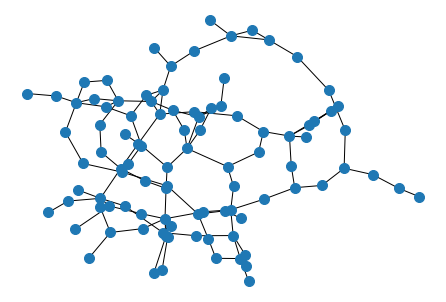

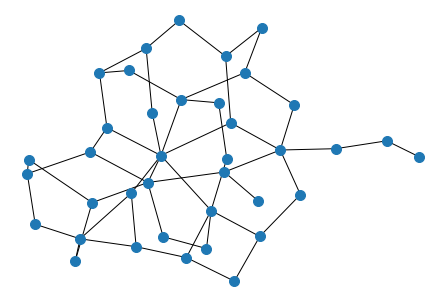

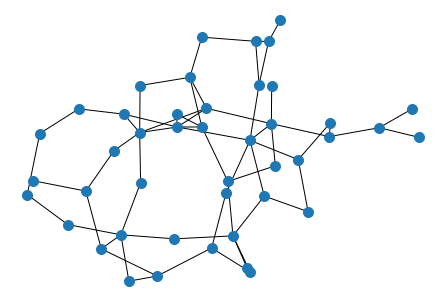

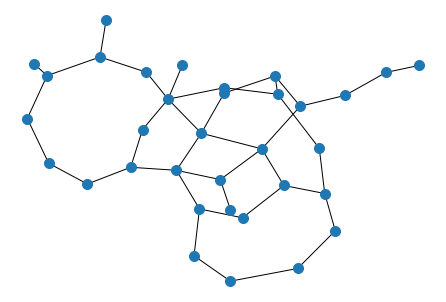

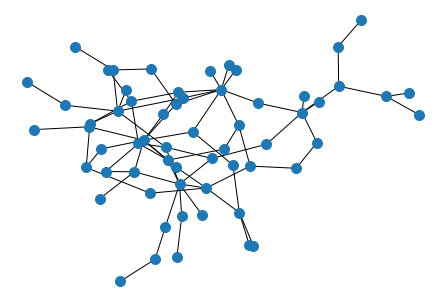

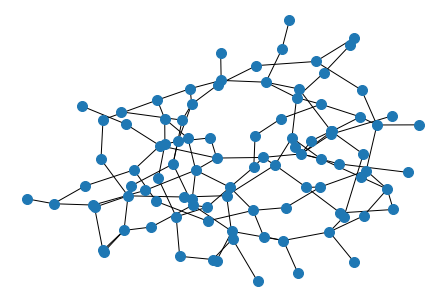

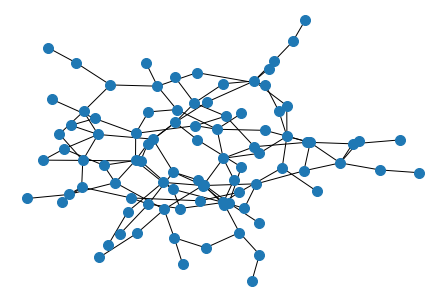

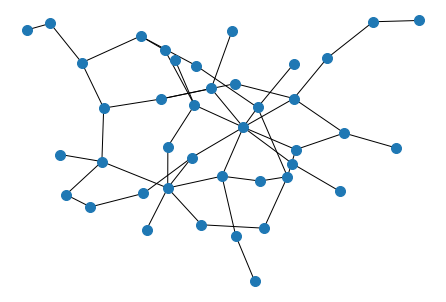

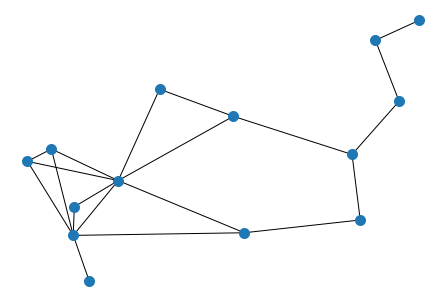

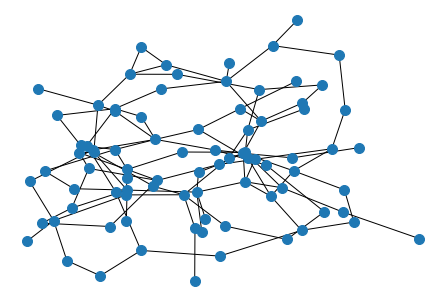

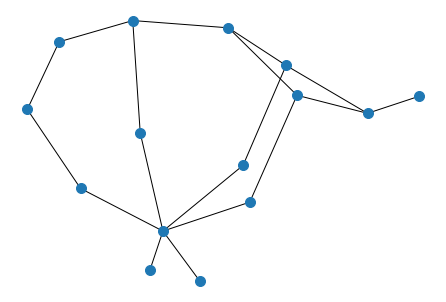

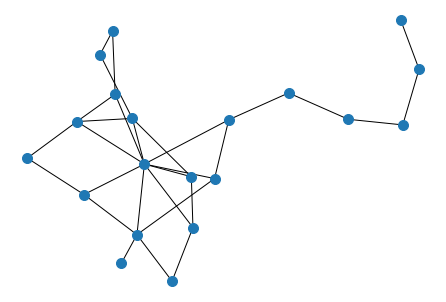

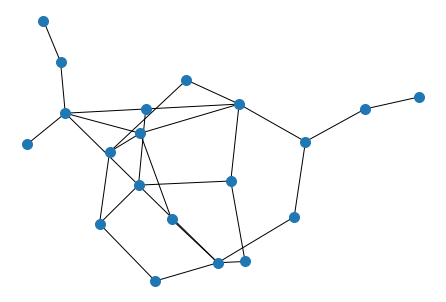

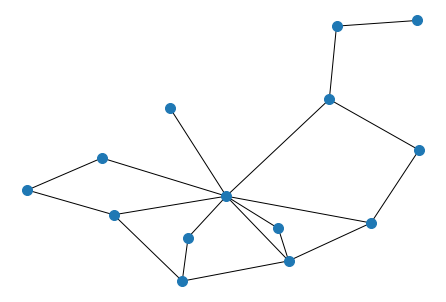

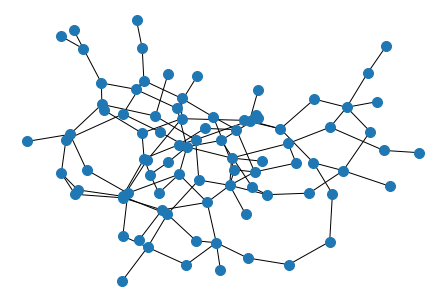

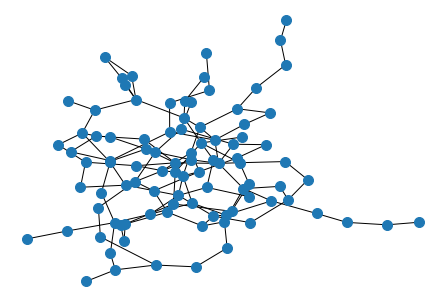

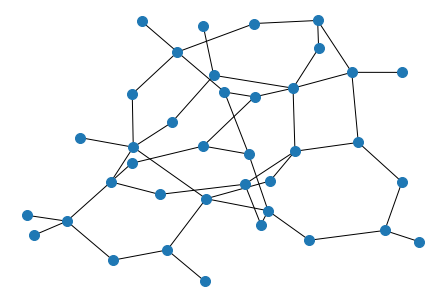

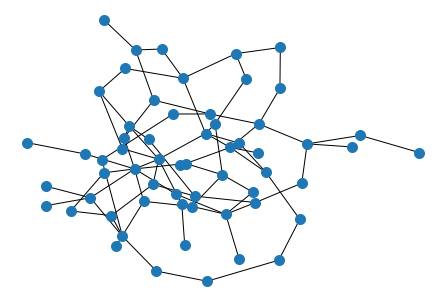

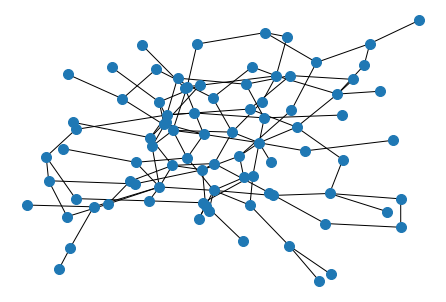

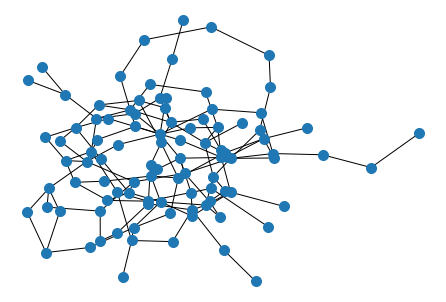

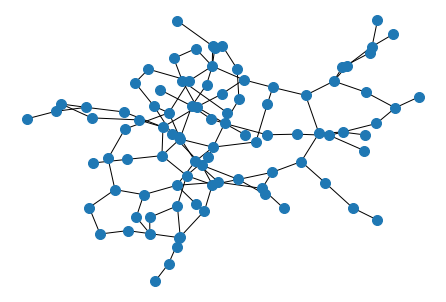

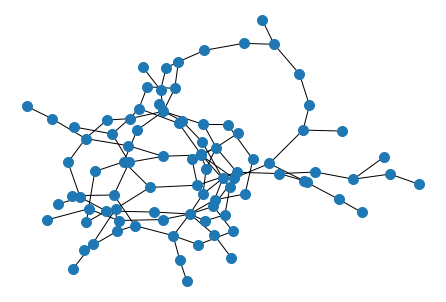

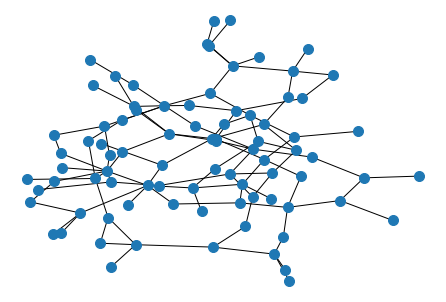

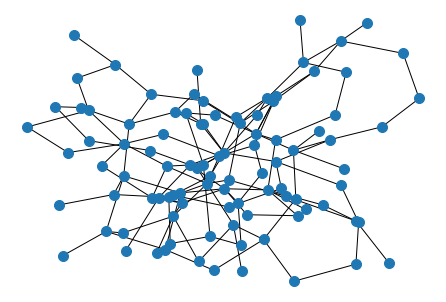

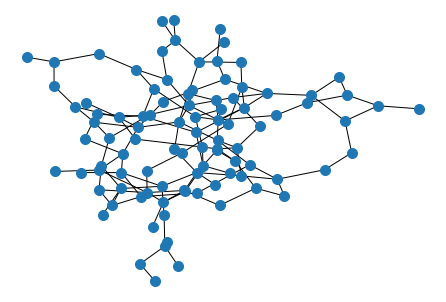

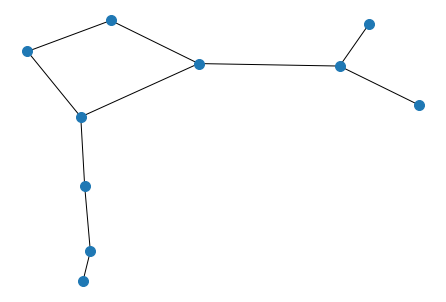

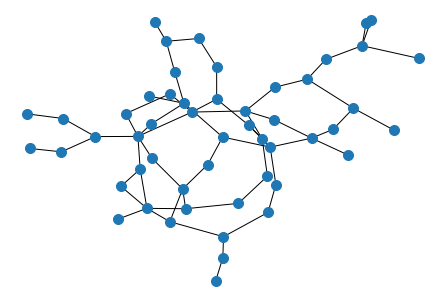

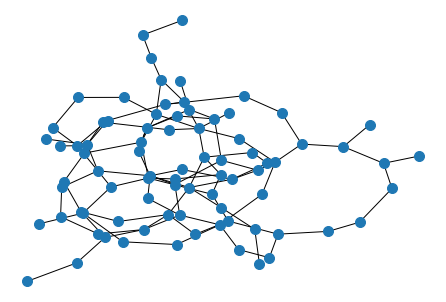

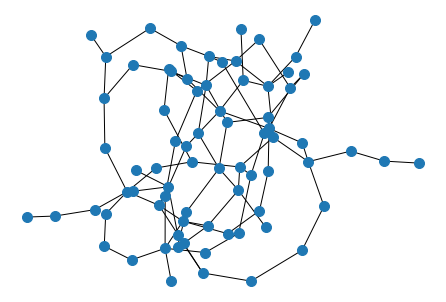

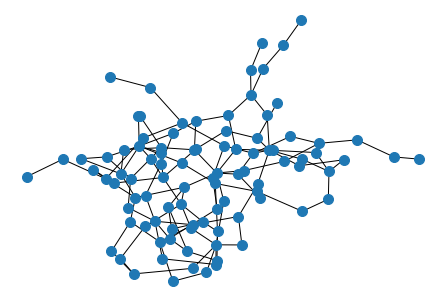

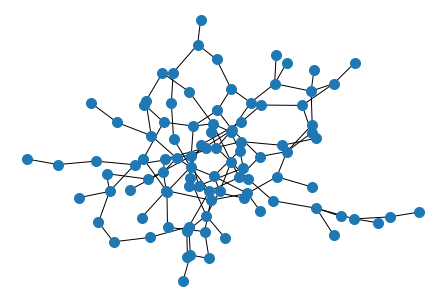

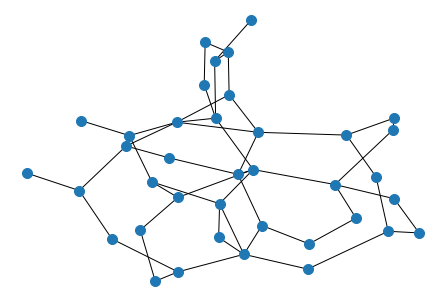

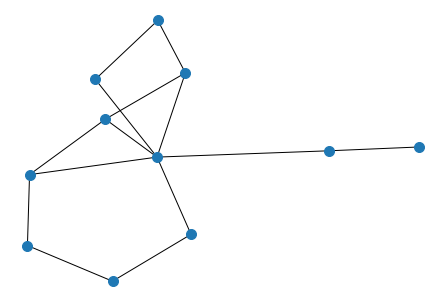

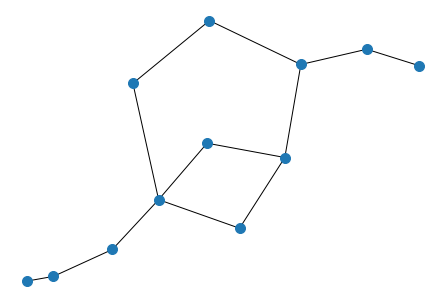

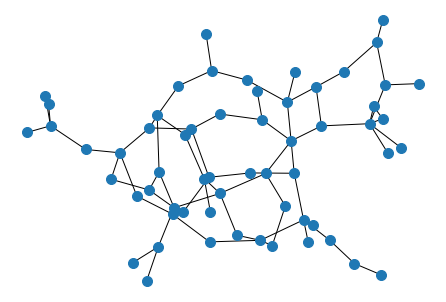

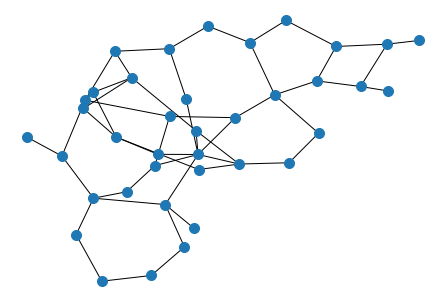

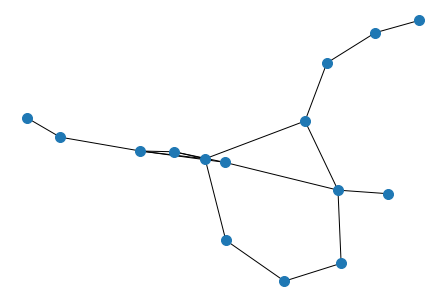

Error in callback <function flush_figures at 0x7f1f85bfa170> (for post_execute):


KeyboardInterrupt: 

In [12]:
criterion = CompositeLoss([EnergyLossVectorized(), MeanStressLoss(), AngularResolutionMeanSineLoss()])
folder_name = f'{config.test.name}_test'
test_loss = []
test_loss_ratio=[]
reso_scores = []
ring_loss = []
reso_loss=[]
minOfMin = []
for test_idx in tqdm(range(10000, 11000)):
    G = G_list[test_idx]
    data = data_list[test_idx]
    node_pos,loss,component = evaluate(model, data,criterion,device, output_components=True)
    node_pos_tensor = torch.tensor(node_pos)
    theta,degree,u = get_theta_angles_and_node_degrees(node_pos_tensor, data,return_u=True)
    gt_loss = ground_truth.loc[test_idx][0]
    loss_ratio = (component[0] - gt_loss) / gt_loss
    minDegree = (theta.min().item()/2*np.pi)*360
    minOfMin.append(minDegree)
    score = resolution_score(theta,degree,u)
    test_loss.append(component[1])
    reso_scores.append(score) 
    reso_loss.append(component[2])
    test_loss_ratio.append(loss_ratio)
    
    graph_vis(G, node_pos, f'{folder_name}/{test_idx}_{component[0]:.2f}_{component[2]:.2f}_{score:.2f}_{minDegree:.2f}.png') 
#     node_pos = nx.nx_agraph.graphviz_layout(G_vis, prog='neato')
#     plt.figure()
#     nx.draw(G_vis, node_pos)
#     plt.savefig(f'{folder_name}/{test_idx}.png')

print("stress",np.nanmean(test_loss), np.nanstd(test_loss))
print("reso loss", np.nanmean(reso_loss), np.nanstd(reso_loss))
print("score",np.nanmean(reso_scores), np.nanstd(reso_scores))
print("min degree", np.nanmean(minOfMin), np.nanstd(minOfMin))
print("loss ratio",np.nanmean(test_loss_ratio), np.nanstd(test_loss_ratio))

In [ ]:
losses = []
loss_ratios = []
for test_idx in tqdm(range(10000, 11000)):
    G_vis = G_list[test_idx]
    node_pos, loss = evaluate(model, data_list[test_idx], criterion, device)
    gt_loss = ground_truth.loc[test_idx][0]
    loss_ratio = (loss - gt_loss) / gt_loss
    losses += [loss]
    loss_ratios += [loss_ratio]

In [ ]:
np.mean(losses), np.std(losses)

In [ ]:
np.mean(loss_ratios), np.std(loss_ratios)

In [ ]:
truth_loss = 0
pred_loss = 0
for idx in tqdm(range(10000, 11000)):
    pred, loss = evaluate(model, data_list[idx], criterion, device)
    pos_map = nx.nx_agraph.graphviz_layout(G_list[idx], prog='neato')

    pred_mean, pred_std = pred.mean(axis=0), pred.std()
    truth = np.array(list(pos_map.values()))
    truth_mean, truth_std = truth.mean(axis=0), truth.std()
    norm_truth = (truth - truth_mean) / truth_std
    scaled_truth = norm_truth * pred_std + pred_mean

    truth_loss += criterion(torch.tensor(scaled_truth), data_list[idx])
    pred_loss += criterion(torch.tensor(pred), data_list[idx])
    
truth_loss / 1000, pred_loss / 1000

In [ ]:
type(data_list[9999].x)

In [ ]:
iterations = 5
losses = []
folder_name = f'{config.test.name}_iterative_test'
for test_idx in tqdm(range(10000, len(G_list))):
    G_vis = G_list[test_idx]
    node_pos = nx.nx_agraph.graphviz_layout(G_vis, prog='neato')
    plt.figure()
    nx.draw(G_vis, node_pos)
    plt.savefig(f'{folder_name}/{test_idx}.png')
    for i in range(iterations):
        node_pos, loss = evaluate(model, data_list[test_idx], criterion, device) 
        data_list[test_idx].x = torch.tensor(node_pos,dtype=torch.float)
    losses += [loss]
    graph_vis(G_vis, node_pos, f'{folder_name}/{config.test.out_prefix}_iter_model_{test_idx}_{loss}.png')

In [ ]:
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(loss_ep[:1000])
plt.show()

In [ ]:
class EnergyLossScaled(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, p, data, scale):
        edge_attr = data.edge_attr
        # convert per-node positions to per-edge positions
        start, end, n_nodes = node2edge(p, data)
        
        start *= scale
        end *= scale
        
        start_x = start[:, 0]
        start_y = start[:, 1]
        end_x = end[:, 0]
        end_y = end[:, 1]
        
        l = edge_attr[:, 0]
        k = edge_attr[:, 1]
        
        term1 = (start_x - end_x) ** 2
        term2 = (start_y - end_y) ** 2
        term3 = l ** 2
        term4 = 2 * l * (term1 + term2).sqrt()
        energy = k / 2 * (term1 + term2 + term3 - term4)
        return energy.sum()

In [ ]:
criterion_scaled = EnergyLossScaled()
criterion = EnergyLossVectorized()

In [ ]:
truth_loss = 0
pred_loss = 0
for idx in tqdm(range(10000, 11000)):
    pred, loss = evaluate(model, data_list[idx], criterion, device)
    pos_map = nx.nx_agraph.graphviz_layout(G_list[idx], prog='neato')

    pred_mean, pred_std = pred.mean(axis=0), pred.std()
    truth = np.array(list(pos_map.values()))
    truth_mean, truth_std = truth.mean(axis=0), truth.std()
    norm_truth = (truth - truth_mean) / truth_std
    scaled_truth = norm_truth * pred_std + pred_mean

    truth_loss += criterion(torch.tensor(scaled_truth, device=device), data_list[idx])
    pred_loss += criterion(torch.tensor(pred, device=device), data_list[idx])
    
truth_loss / 1000, pred_loss / 1000

In [ ]:
for idx in [10898, 10904]:#tqdm(range(10000, 11000)):
    data, G = data_list[idx], G_list[idx]
    edge_attr = data.edge_attr
    pred, loss = evaluate(model, data, criterion, device)
    pos_map = nx.nx_agraph.graphviz_layout(G, prog='neato')
    truth = np.array(list(pos_map.values()))

    start, end, n_nodes = node2edge(torch.tensor(truth, device=device), data)
    w = edge_attr[:, 1]
    d = edge_attr[:, 0]

    u2 = ((start - end) ** 2).sum(dim=1)

    s = (w * d * u2.sqrt()).sum() / (w * u2).sum()

    loss_gt = criterion_scaled(torch.tensor(truth, device=device), data, s)

    print(loss, loss_gt)

In [ ]:
def evaluate(model, data, criterion, device, idx):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        pred = model(data).detach()
        loss = criterion(pred,data).cpu().numpy()
        loss = round(float(loss),2)
    return pred.cpu().numpy(), loss

def graph_vis(G, node_pos):
    i = 0
    for n, p in node_pos:
        node = 'n' +str(i)
        G.nodes[node]['pos'] = (n,p)
        i += 1
    pos = nx.get_node_attributes(G,'pos')
    plt.figure()
    nx.draw(G, pos)
    
for test_idx in tqdm(list(range(10000, len(data_list)))):
    G_vis = G_list[test_idx]
    node_pos,loss = evaluate(model, data_list[test_idx],criterion,device, test_idx)
    if loss > 10000:
        print(test_idx, loss, data_list[test_idx].num_nodes)
        graph_vis(G_vis, node_pos) 
        node_pos = nx.nx_agraph.graphviz_layout(G_vis, prog='neato')
        plt.figure()
        nx.draw(G_vis, node_pos)

# Eval with Projection

In [ ]:
idx = 10117
pred, loss, sloss, aloss = evaluate(model, data_list[idx], criterion, device, output_components=True, reduction=umap_project)
graph_vis(G_list[idx], pred, f'composite_umap_{idx}_loss_{sloss}_{aloss}.png')
print(sloss, aloss)

# Iterative Evaluation

In [ ]:
iterations = 100
losseses = []
folder_name = f'{config.test.name}_iterative_test'
if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
for test_idx in tqdm(range(10000, 10500)):
    G_vis = G_list[test_idx]
#     node_pos = nx.nx_agraph.graphviz_layout(G_vis, prog='neato')
#     plt.figure()
#     nx.draw(G_vis, node_pos)
#     plt.savefig(f'{folder_name}/{test_idx}.png')
    losses = []
    for i in range(iterations):
        node_pos, loss, stress, angle = evaluate(model, data_list[test_idx], criterion, device, output_components=True, with_initial_pos=True) 
        data_list[test_idx].x = torch.tensor(node_pos,dtype=torch.float)
        losses += [loss]
    losseses += [losses]
    graph_vis(G_vis, node_pos, f'{folder_name}/{config.test.out_prefix}_iter_model_{test_idx}_{stress}_{angle}.png')

In [ ]:
_, bins, _ = plt.hist(np.array(losseses).std(axis=1), bins=10)
plt.clf()
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
count, bins, _ = plt.hist(np.array(losseses).std(axis=1), bins=logbins, rwidth=0.5, log=False)
plt.xscale('log')
plt.title('Distribution of std(loss)')

In [ ]:
pd.options.display.float_format = '{:,.2e}'.format
pd.DataFrame([bins[:-1], bins[1:], count], index=['min', 'max', 'count']).T.astype({'count': 'int64'})

# Visualization

In [ ]:
model = torch.load(f'../ckpt_{config.name}/epoch_{config.test.epoch}.pt', map_location=torch.device(device))

In [ ]:
G, data = G_list[0], data_list[0]

In [ ]:
hidden = model(data, output_hidden=True, numpy=True)[1:10]
projected = list(map(pca_project, hidden))
for i in range(9):
    graph_vis(G, projected[i])

In [ ]:
torch.tensor([1,2,3]).square()